In [43]:
#!pip install seaborn
#%pip uninstall seaborn -y
#pip install seaborn
import seaborn as sns
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob

from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import scale, normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

from sklearn.feature_selection import RFE

In [56]:
frequency_range = (100, 350)

feature_file_path = f"features/vag_features_{str(frequency_range[0])}_{str(frequency_range[1])}.csv"
f_df = pd.read_csv(feature_file_path)
print(f_df.head(2))

   STATE        FD    FD_EXT    FD_FLX       VMS       VMS_EXT       VMS_FLX  \
0      1  1.714624 -2.449159 -2.389366  0.003594  1.172150e-08  4.956498e-08   
1      1  1.876535 -2.966521 -3.259061  0.017189  2.155439e-08  4.883802e-08   

            LI      LI_EXT      LI_FLX  
0   684.049676   75.651090  103.905869  
1  1746.572715  154.977514  160.024887  


### K-nearest neighbours classification

In [57]:
# KNN
data = f_df.copy()
# labels
y = np.array(data["STATE"], dtype=np.int32)  # Convert labels to int32
# data
X = data.drop(columns=["STATE"], axis=1)
data['Original Index'] = data.index
X_FD = data["FD"].to_numpy().reshape(-1, 1)

# split 0.5 = 50:50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

test_indices = data.loc[X_test.index, 'Original Index'].reset_index(drop=True)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("confusion matrix")
print(conf_matrix)
print(class_report)

from sklearn.inspection import permutation_importance

# Train the KNN model
# Compute permutation importance
results = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Get importance scores
importance = results.importances_mean

features = X.columns.tolist()
# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature {features[i]}: {v:.3f}')

# check the test index 
predictions_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred,
    'Original Index': test_indices.reset_index(drop=True)  # Ensure indices align
})

# Display the results of the test data
print()
predictions_df

Accuracy: 0.9111111111111111
Precision: 0.8787878787878788
Recall: 1.0
confusion matrix
[[12  4]
 [ 0 29]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.88      1.00      0.94        29

    accuracy                           0.91        45
   macro avg       0.94      0.88      0.90        45
weighted avg       0.92      0.91      0.91        45

Feature FD: 0.282
Feature FD_EXT: 0.004
Feature FD_FLX: 0.016
Feature VMS: 0.009
Feature VMS_EXT: -0.056
Feature VMS_FLX: 0.009
Feature LI: 0.093
Feature LI_EXT: 0.002
Feature LI_FLX: 0.022



,True Label,Predicted Label,Original Index
0,1,1,44
1,0,0,53
2,1,1,30
3,1,1,12
4,1,1,49
5,1,1,0
6,0,0,64
7,1,1,18
8,1,1,10
9,1,1,22


#### Plot the accuracy

Text(0, 0.5, 'Accuracy Score')

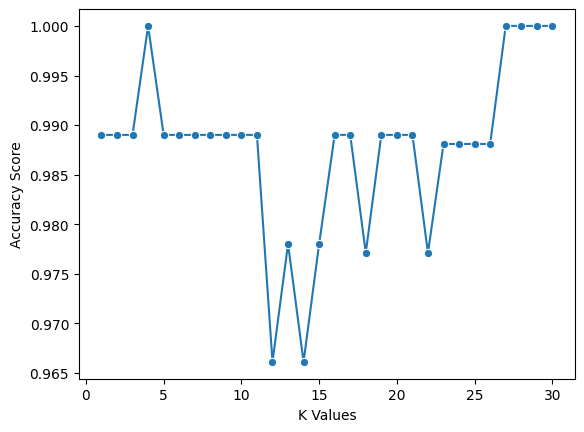

In [58]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=7)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

### KMeans Custering (Unsupervised)

In [59]:
actual_groups = f_df["STATE"].to_numpy()
features_wo_group = f_df.copy()
features_wo_group = features_wo_group.drop(["STATE"], axis=1)
print(features_wo_group.head(2))

         FD    FD_EXT    FD_FLX       VMS       VMS_EXT       VMS_FLX  \
0  1.714624 -2.449159 -2.389366  0.003594  1.172150e-08  4.956498e-08   
1  1.876535 -2.966521 -3.259061  0.017189  2.155439e-08  4.883802e-08   

            LI      LI_EXT      LI_FLX  
0   684.049676   75.651090  103.905869  
1  1746.572715  154.977514  160.024887  


In [60]:
#data_scaled = features_wo_group

# scale data?
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_wo_group)

kmeans = KMeans(n_clusters=2, random_state=42, max_iter=300).fit(data_scaled)
print(f"predicted groups: {kmeans.labels_}")
print(f"actual groups:    {actual_groups}")

k_means_class0 = [x for x in kmeans.labels_ if x == 0]
k_means_class1 = [x for x in kmeans.labels_ if x == 1]
print()
print(f"number of 0's: {len(k_means_class0)}")
print(f"number of 1's: {len(k_means_class1)}")

correct = []
num_correct = 0
for i in range(0, len(kmeans.labels_)):
    if(kmeans.labels_[i] == actual_groups[i]):
        correct.append(True)
        num_correct += 1
    else:
        correct.append(False)
print()
print(correct)
print(f" num of correct: {num_correct}")

predicted groups: [1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
actual groups:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

number of 0's: 22
number of 1's: 67

[True, False, False, True, False, True, False, False, True, False, False, False, True, True, True, True, True, True, False, False, True, False, True, True, True, False, True, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa

In [61]:
pca = PCA(n_components=2)
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(metrics_wo_patients)
X_pca = pca.fit_transform(data_scaled)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, index=features_wo_group.columns, columns=['PC1', 'PC2'])

print(loading_df)

              PC1       PC2
FD       0.568307 -0.453428
FD_EXT   0.022337 -0.448356
FD_FLX  -0.150708 -0.479476
VMS      0.772702 -0.285123
VMS_EXT -0.140650  0.576999
VMS_FLX -0.031018 -0.270766
LI       0.956083 -0.102015
LI_EXT   0.781449  0.474272
LI_FLX   0.807969  0.266627


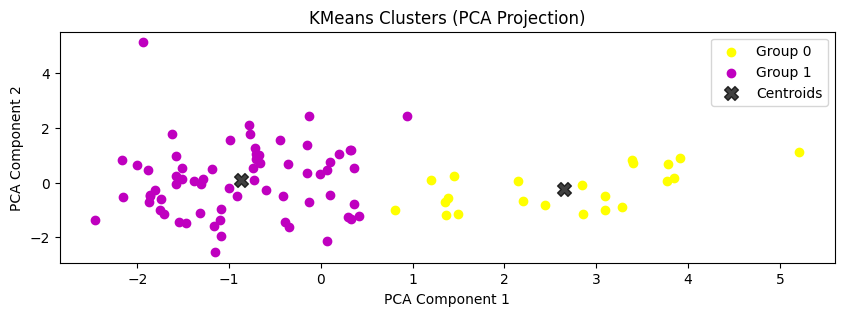

In [62]:
# Create a scatter plot
plt.figure(figsize=(10, 3))

# Define colors for each group
colors = {0: 'yellow', 1: 'm', 2: 'c', 3:'b', 4:'r'}  # Add more colors if you have more groups

# Plot each group with its corresponding color
for group in np.unique(kmeans.labels_):
    plt.scatter(X_pca[kmeans.labels_ == group, 0], 
                X_pca[kmeans.labels_ == group, 1], 
                color=colors[group], 
                label=f'Group {group}')

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, alpha=0.75, marker='X', label='Centroids')

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters (PCA Projection)')

# Add legend
plt.legend()
plt.show()